# **Simulazione di baseline (senza controllo)**

Questa simulazione prende un algoritmo fornito direttamente dalla libreria di CityLearn. Questo agente viene utilizzato per simulazioni di base (business as usual), senza controllo su accumuli o pompe di calore. L'ambiente con questa simulazione viene modificato per non aspettarsi azioni attive, e ciò ci risulta utile per la libreria per creare una simulazione di riferimento da confrontare con gli altri agenti.
In questo esempio ignoriamo il funzionamento di questo algoritmo, e lo utilizziamo per estrappolare alcune serie temporali per comprendere al meglio la struttura dell'ambiente. Verrano mostrate le variazioni di temperatura all'interno e all'esterno dell'edificio, e i consumi di energia dei dispositivi di riscaldamento/raffredamento per comprendere quanto lavoro viene effettuato da essi.


**Lista degli import**

In [1]:
from citylearn.agents.base import BaselineAgent as Agent
from citylearn.citylearn import CityLearnEnv

#import per strutture dati
import pandas as pd
from datetime import datetime

#import per grafici
from utils import plotting_functions as plt

#permette di nascondere i warning
import warnings
warnings.filterwarnings("ignore")


Couldn't import dot_parser, loading of dot files will not be possible.


Questa parte di codice permette di avviare una simulazione utilizzando l'agente di Baseline, in questo caso la simulazione verrà effettuata su tutti gli edifici della building ma al termine estrarremmo le informazioni soltanto da un edificio (per semplicità di rappresentazione).
Il flag **central_agent** permette che la lista delle azioni sia un array con tutte le azioni possibili su tutti i building del distretto.
Il flag **truncated** se vero avverte che uno step è terminato a causa di un time limit o una motivazione indefinita

In [2]:
# Inizializza l'ambiente
# citylearn_challenge_2023_phase_2_local_evaluation è una simulazione nel mese di GIUGNO
env = CityLearnEnv('citylearn_challenge_2023_phase_2_local_evaluation', central_agent=True)

# Inizializza l'agente
model = Agent(env)
# Resetto la simulazione allo step iniziale
observations, _ = env.reset()

# Seleziona un preciso edificio nell'ambiente
num_building = 0

while not env.terminated:
    actions = model.predict(observations)

    #Ottengo i dati osservati per un solo edificio
    #obs_data = env.buildings[num_building]._get_observations_data()
    #display(env.buildings[num_building].cooling_device.get_metadata())
    #Effettua uno step nell simulazione restitudendo i seguendi flag/informazioni
    observations, reward, info, terminated, truncated = env.step(actions)

#display(obs_data)

Di seguito vengono estrappolati i dati di osservazioni complessivi dall'ambiente per effettuarne così una valutazione. Successivamente richiamamo le funzioni di plotting definiti per graficare i risultati

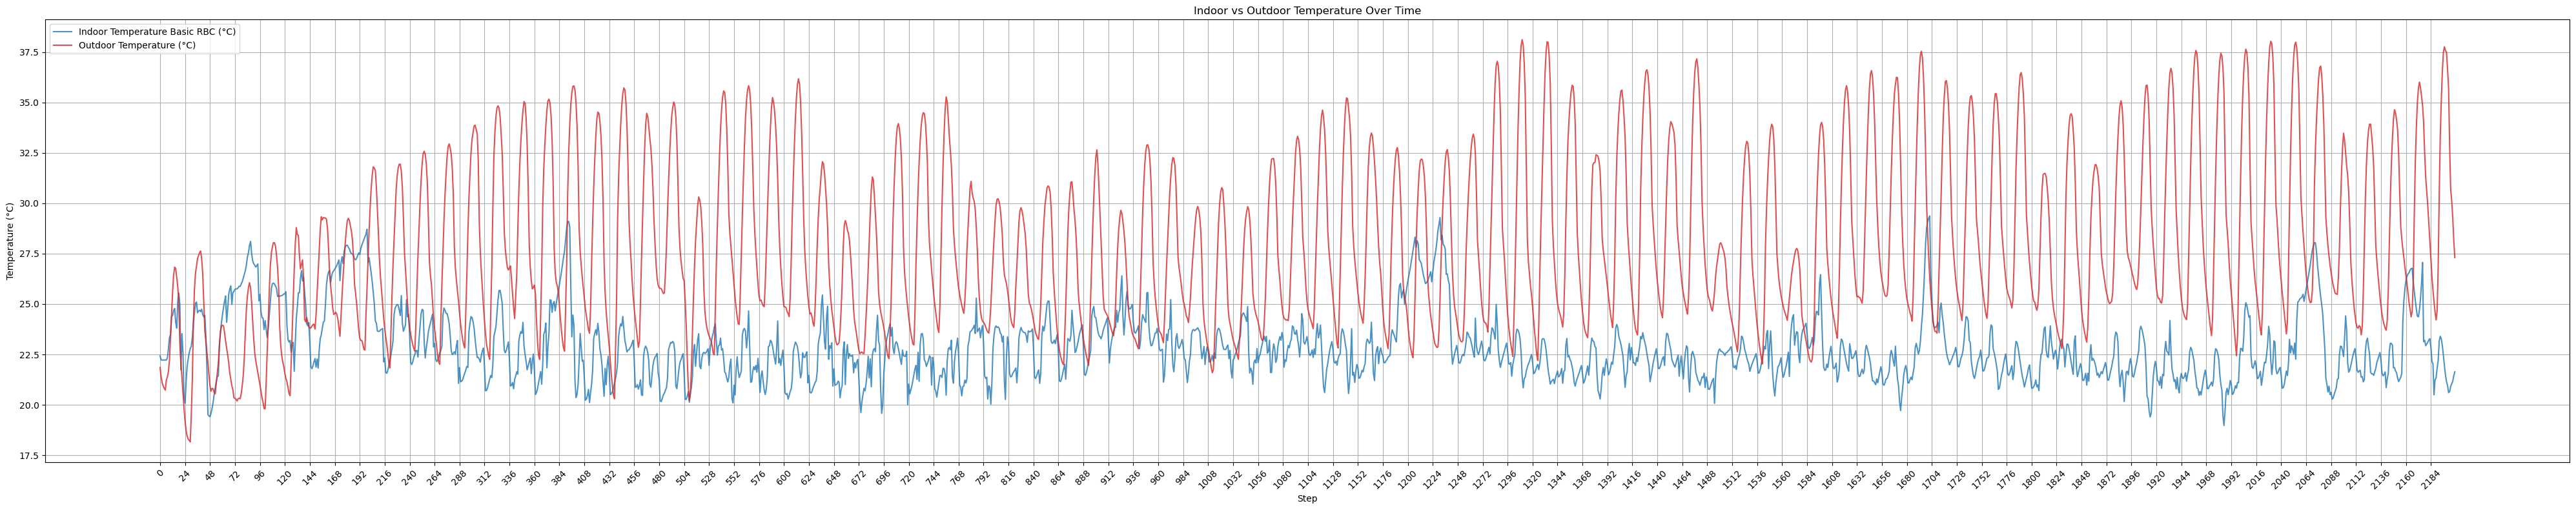

In [3]:
indoor_temp = env.buildings[num_building].indoor_dry_bulb_temperature
outdoor_temp = env.buildings[num_building].weather.outdoor_dry_bulb_temperature

plt.plot_comparison_two(
    indoor_temp,
    outdoor_temp,
    ylabel='Temperature (°C)',
    title='Indoor vs Outdoor Temperature Over Time',
    label1='Indoor Temperature Basic RBC (°C)',
    label2='Outdoor Temperature (°C)'
)


Mostriamo l'energia utilizzata dai dispositivi di riscaldamento/raffredamento per poter visualizzare il lavoro effettuato per regolare la temperatura nelle varie situazioni.

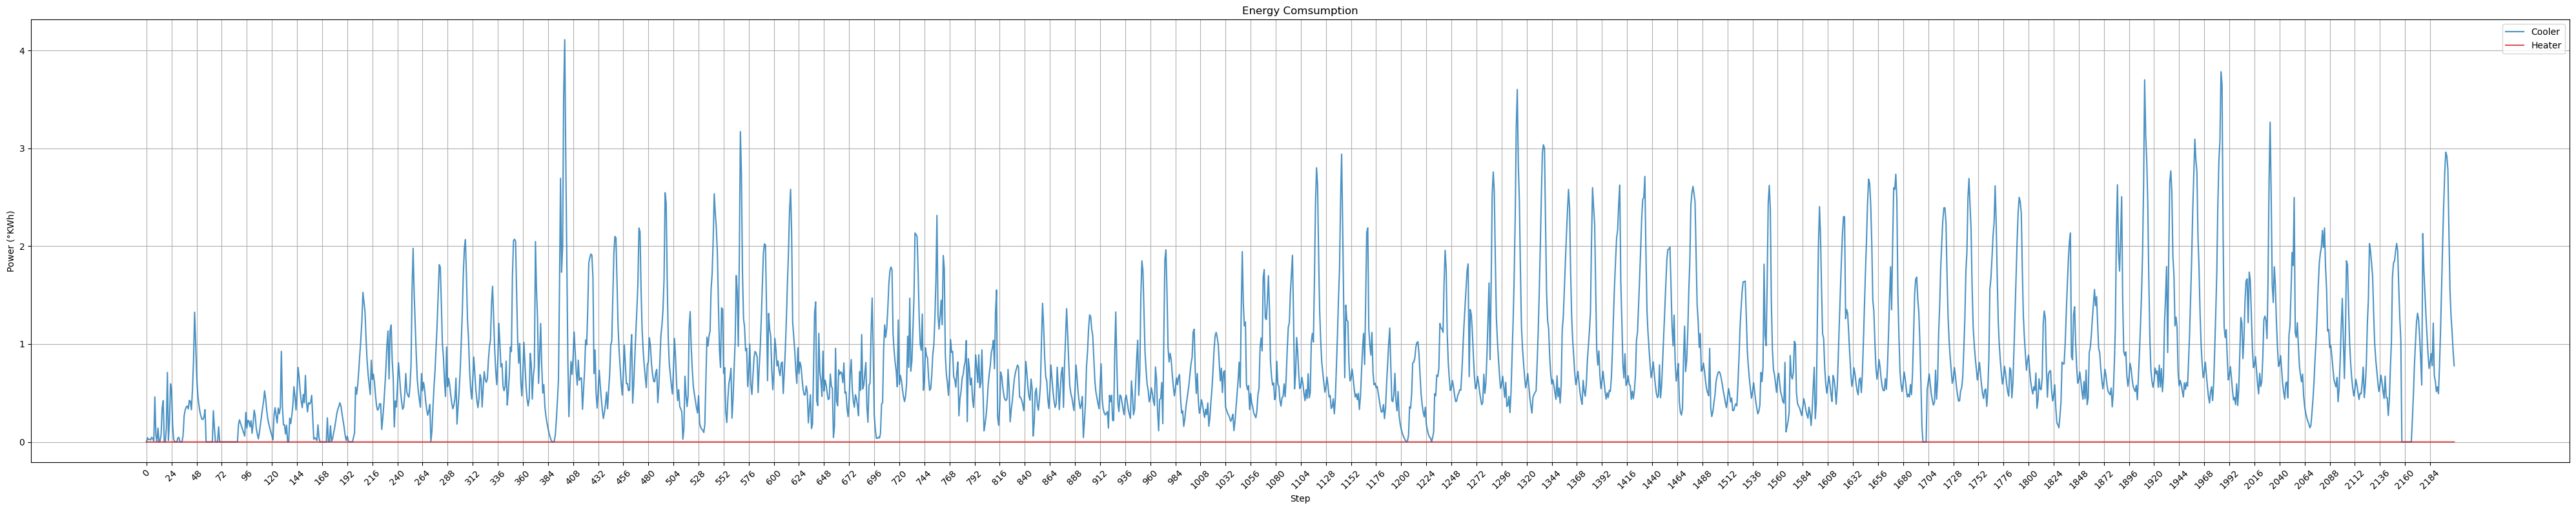

In [4]:
#Questa componente estrae la potenza utilizzata dei dispositivi che servono per regolare la temperatura ambientale

cooler_energy = env.buildings[num_building].cooling_electricity_consumption
heater_energy = env.buildings[num_building].heating_electricity_consumption

plt.plot_comparison_two(
    cooler_energy,
    heater_energy,
    ylabel='Power (°KWh)',
    title='Energy Comsumption',
    label1='Cooler',
    label2='Heater'
)

Per completezza vengono aggiunti i consumi generali della casa, che comprendono tutti i dispositivi e accumulatori collegati.

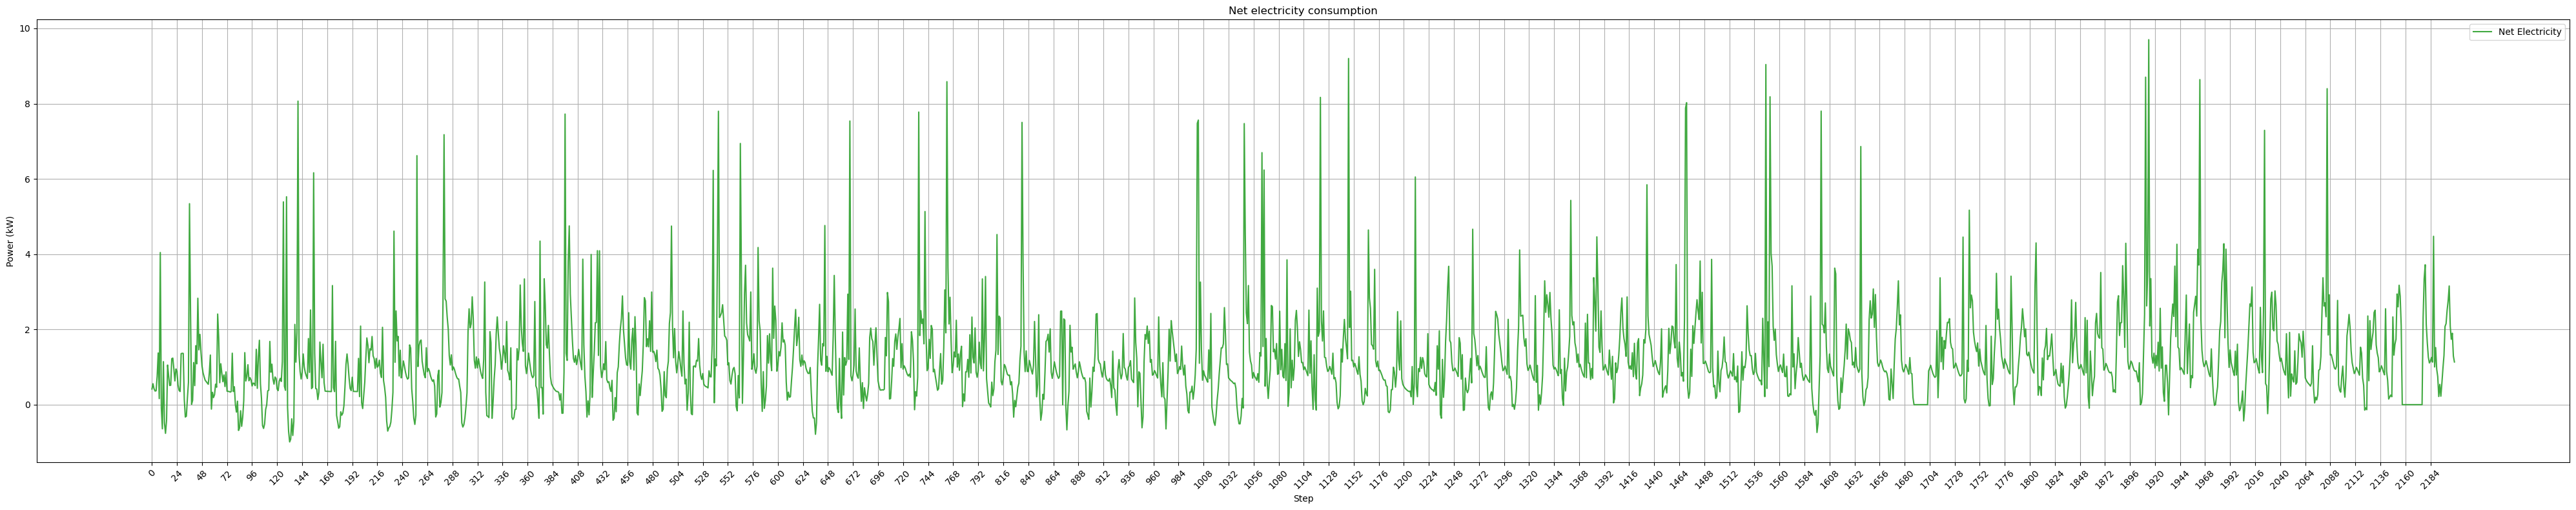

In [5]:
#Calcola il consumo di elettricità totale dell'edificio
net_electricity_consumption_log = env.buildings[num_building].net_electricity_consumption

plt.plot_single_agent(
    net_electricity_consumption_log,
    ylabel='Power (kW)',
    title='Net electricity consumption',
    label='Net Electricity'
)

La parte seguente viene fornita direttamente dalla documentazione di CityLearn e effettua una valutazione dell'algoritmo sulle **cost_function**. Alcune di esse sono a NaN in quanto sono esclusivamente valori riguardanti a distretti interi.

In [6]:
# Vengono filtrare le cost_function desiderate
kpis_names = { 'electricity_consumption_total':'Consumo totale della rete',
               'carbon_emissions_total':'Emissioni',
              'discomfort_proportion':'Proporzione del tempo fuori dal comfort',
              'daily_peak_minus_load_factor_average': 'Misura dell inefficenza nell uso giornaliero della potenza disponibile',
              'daily_peak_average': 'Picco medio giornaliero',
              'all_time_peak_average': 'picco massimo dei consumi nel distretto',
              'one_minus_thermal_resilience_proportion': 'Discomfort proportion in interruzioni elettriche',
              'annual_normalized_unserved_energy_total': 'domanda non soddisfatta a causa di carenza di energia'
              #Qua si aggiungono cost_function
}
kpis = model.env.evaluate()
kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
display(kpis)

name,Building_1,Building_2,Building_3,Building_4,Building_5,Building_6,District
cost_function,,,,,,,
all_time_peak_average,NaN,NaN,NaN,NaN,NaN,NaN,1.000
annual_normalized_unserved_energy_total,0.015,0.014,0.013,0.013,0.014,0.016,0.014
carbon_emissions_total,1.000,1.000,1.000,1.000,1.000,1.000,1.000
daily_peak_average,NaN,NaN,NaN,NaN,NaN,NaN,1.000
discomfort_proportion,0.293,0.033,0.056,0.326,0.070,0.027,0.134
electricity_consumption_total,1.000,1.000,1.000,1.000,1.000,1.000,1.000
one_minus_thermal_resilience_proportion,0.455,0.789,0.667,0.424,0.913,0.667,0.652
